In [1]:
import networkx as nx
import multiprocessing as mp

In [2]:
def vcol(t):
    if t == 0: return 'black'
    if t == 1: return 'green'
    if t == 2: return 'red'
    return 'white'

def zigzag(sz):
    g = nx.Graph()
    g.add_nodes_from(range(2*sz+4), t=0)
    for i in range(1,sz+1):
        g.node[2*i]['t'] = (i%2)+1
        g.node[2*i+1]['t'] = (i%2)+1
    g.add_edges_from([(0,2),(1,3)])
    g.add_edges_from([(2*i,2*i+2) for i in range(1,sz)])
    g.add_edges_from([(2*i,2*i+3) for i in range(1,sz)])
    g.add_edges_from([(2*i+1,2*i+2) for i in range(1,sz)])
    g.add_edges_from([(2*i+1,2*i+3) for i in range(1,sz)])
    g.add_edges_from([(2*sz,2*sz+2),(2*sz+1,2*sz+3)])
    return g

def match_bialg(g, interior=False):
    for e in g.edges():
        v0 = e[0]
        v1 = e[1]
        v0t = g.node[v0]['t']
        v1t = g.node[v1]['t']
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            if (
                not interior or (
                all([g.node[n]['t'] == v1t for n in g.neighbors(v0)]) and
                all([g.node[n]['t'] == v0t for n in g.neighbors(v1)]))
            ):
                return [v0,v1]
    return None


def match_bialg_int(g):
    return match_bialg(g, interior=True)

def bialg(g, match, check=False):
    v0 = match[0]
    v1 = match[1]
    v0t = g.node[v0]['t']
    v1t = g.node[v1]['t']

    if check:
        if not (
            g.has_edge(v0,v1) and
            ((v0t == 1 and v1t == 2) or
            (v0t == 2 and v1t == 1))
        ): return False
    
    n0 = [n for n in g.neighbors(v0) if n != v1]
    n1 = [n for n in g.neighbors(v1) if n != v0]
    
    # add dummy nodes around v0, v1 as necessary.
    for i in range(len(n0)):
        if (g.node[n0[i]]['t'] != v1t):
            newv = len(g.nodes)
            g.add_node(newv)
            g.node[newv]['t'] = v1t
            g.remove_edge(v0,n0[i])
            g.add_edges_from([(n0[i], newv), (newv, v0)])
            n0[i] = newv
    
    for i in range(len(n1)):
        if (g.node[n1[i]]['t'] != v0t):
            newv = len(g.nodes)
            g.add_node(newv)
            newv['t'] = v0t
            g.remove_edge(v1,n1[i])
            g.add_edges_from([(v1,newv),(newv,n1[i])])
            n1[i] = newv
    
    for s in n0:
        for t in n1:
            if g.has_edge(s,t): g.remove_edge(s,t)
            else: g.add_edge(s,t)
    
    
    # delete vertices at the end so we don't mess up indices
    g.remove_nodes_from([v0,v1] + [v for v in n0 + n1 if g.degree(v) < 2])
    return True

def draw(g):
    return nx.draw(g, node_color=[vcol(g.node[v]['t']) for v in g.nodes()], node_size=20)

In [3]:
%time g = zigzag(5000)
%time m = match_bialg(g, interior=True)
%time bialg(g, m)

CPU times: user 203 ms, sys: 62.5 ms, total: 266 ms
Wall time: 259 ms
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 123 µs


True

CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 90.9 ms
simplifying graph with 10004 nodes and 20000 edges...
CPU times: user 13.7 s, sys: 31.2 ms, total: 13.7 s
Wall time: 13.8 s


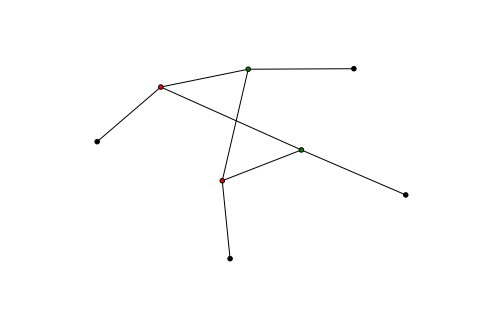

In [10]:
%time g = zigzag(5000)
print('simplifying graph with ' + str(len(g.nodes())) + ' nodes and ' + str(len(g.edges())) + ' edges...')
def f():
    while True:
        m = match_bialg(g, interior=True)
        if m: bialg(g, m)
        else: break
%time f()
draw(g)

In [14]:
def noop(g):
    return g

def nf(g):
    while True:
        m = match_bialg(g, interior=True)
        if m: bialg(g, m)
        else: break
    return g

%time gs = [zigzag(500) for i in range(1000)]
%time pool = mp.Pool(processes=8, initializer=lambda: print(mp.current_process().name))
%time output = pool.map(nf,gs)

CPU times: user 9.73 s, sys: 4.58 s, total: 14.3 s
Wall time: 15.2 s
ForkPoolWorker-25
ForkPoolWorker-26
ForkPoolWorker-27
ForkPoolWorker-28
ForkPoolWorker-29
ForkPoolWorker-30
ForkPoolWorker-31
ForkPoolWorker-32
CPU times: user 78.1 ms, sys: 4.75 s, total: 4.83 s
Wall time: 4.95 s
CPU times: user 2.94 s, sys: 1.42 s, total: 4.36 s
Wall time: 40.5 s
